<a href="https://colab.research.google.com/github/kavyajeetbora/PSENet.pytorch/blob/master/PSENet_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing softwares and other dependencies

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [38]:
!pip install pyclipper

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import shutil, os
os.chdir('/content')
directory = '/content/cloned-repo'
if os.path.exists(directory):
  shutil.rmtree(directory)

!git clone https://github.com/kavyajeetbora/PSENet.pytorch.git /content/cloned-repo
print("Cloned the repository")
os.chdir('/content/cloned-repo')
!ls

Cloning into '/content/cloned-repo'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 522 (delta 72), reused 0 (delta 0), pack-reused 400
Receiving objects: 100% (522/522), 8.94 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Cloned the repository
cal_recall  install_dependencies.sh  PSENet.ipynb	     train.py
config.py   LICENSE		     PSENet_predict.ipynb    utils
dataset     models		     PSENet_training.ipynb
eval.py     predict.py		     PSENet_trial_run.ipynb
imgs	    pse			     README.md


## Extracting the data and setting up the dataset

In [0]:
## unzipping the files
from zipfile import ZipFile

def unzip_files(file,output_dir):
  with ZipFile(file, 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(output_dir)
  print('Extracted to',output_dir)

def make_directory(directory):
  if os.path.isdir(directory):
    shutil.rmtree(directory)
  
  os.mkdir(directory)
  print('Created a new directory')

test_data_zip = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/real_Image_dataset_Detection.zip'
model_path = '/content/drive/My Drive/PSENet_2/PSENet_resnet50.pth'

In [42]:
make_directory('Test Set')

Created a new directory


In [43]:
%%time
unzip_files(test_data_zip,'Test Set')

Extracted to Test Set
CPU times: user 515 ms, sys: 112 ms, total: 627 ms
Wall time: 638 ms


In [44]:
print(len(os.listdir('Test Set/Images')))

428


In [45]:
print(len(os.listdir('Test Set/Annotations')))

428


In [0]:
# model_path = 'output/psenet_icd2015_new_loss/final.pth'
image_root = 'Test Set/Images'
annotation_root = 'Test Set/Annotations'

Images = os.listdir(image_root)
Labels = os.listdir(annotation_root)

## Dectect Text

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
from pse import decode as pse_decode

def predict(net, img: str, device,long_size: int = 2240, scale=1):
  
  assert os.path.exists(img), 'file is not exists'
  img = cv2.imread(img)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  scale = long_size / max(h, w)
  img = cv2.resize(img, None, fx=scale, fy=scale)
  # 将图片由(w,h)变为(1,img_channel,h,w)
  tensor = transforms.ToTensor()(img)
  tensor = tensor.unsqueeze_(0)

  tensor = tensor.to(device)
  with torch.no_grad():
    torch.cuda.synchronize()
    start = time.time()
    preds = net(tensor)
    preds, boxes_list = pse_decode(preds[0], scale)
    scale = (preds.shape[1] / w, preds.shape[0] / h)
    # print(scale)
    # preds, boxes_list = decode(preds,num_pred=-1)
    if len(boxes_list):
        boxes_list = boxes_list / scale
    torch.cuda.synchronize()
    t = time.time() - start
  return preds, boxes_list, t

In [0]:
import config
from models import PSENet

net = PSENet(backbone='resnet50', pretrained=False, result_num=config.n)
state_dict = torch.load(model_path, map_location=device)
net.load_state_dict(state_dict)
net = net.to(device)

In [0]:
from utils.utils import show_img, draw_bbox

def text_detection(net,image_list,image_root,device):
  image_id = image_list[np.random.randint(1,len(image_list)+1)].split('.jpg')[0]
  img_path = image_root+os.sep+'{}.jpg'.format(image_id)
  print('Predicting for image',img_path)
  preds, boxes_list,t = predict(net,img_path,device)
  show_img(preds)
  img = draw_bbox(img_path, boxes_list, color=(0, 0, 255))
  cv2.imwrite('result.jpg', img)
  plt.figure(figsize=(15,10))
  plt.imshow(img)
  plt.show()

Predicting for image Test Set/Images/283.jpg


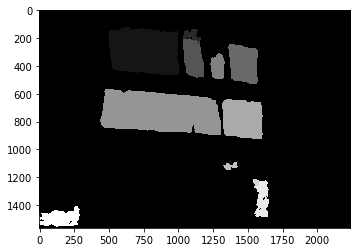

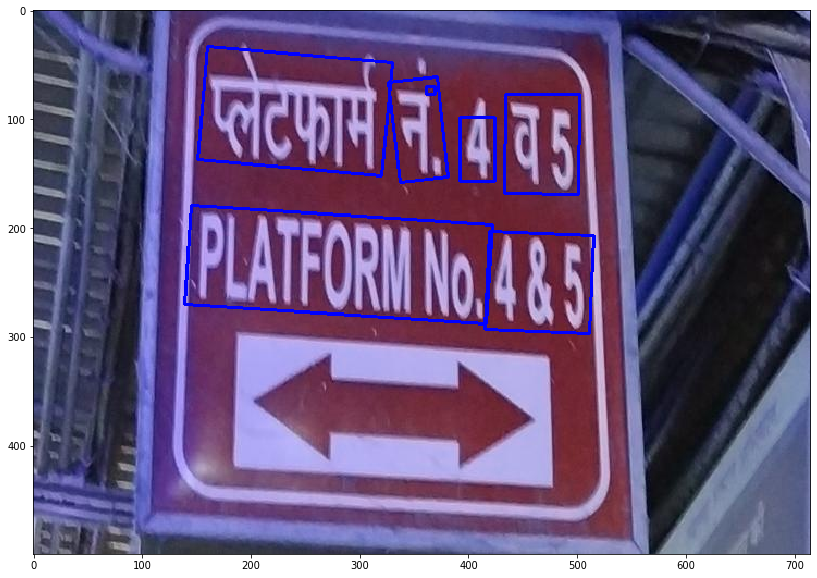

In [83]:
text_detection(net,Images,image_root,device)